<a href="https://colab.research.google.com/github/rishi-analytics/Machine-Learning-With-PySpark/blob/main/Machine_Learning_With_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Project Using PySpark**

## Project Summary

**Customer Churn Prediction Project**

This project aims to analyze customer data and build a machine learning model to predict customer churn for a telecom company.  

- Steps executed: data cleaning, feature engineering, and model training using PySpark, focusing on decision trees.  

Key steps covered:  
- Data loading and exploratory data analysis  
- Handling missing values and outliers  
- Feature preparation: encoding categorical variables and scaling numerical features  
- Model training, evaluation, and hyperparameter tuning  
- Feature importance analysis and business recommendations  

The goal is to identify drivers of churn and provide actionable insights to reduce customer loss.




### **Task 1 - Loading data**

Installing the pyspark using pip

In [ ]:
!pip install pyspark

Importing Modules

In [ ]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [ ]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()spark

Loading our data

-> For loading data, first step is to mount the google drive (this is my prefered method).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/ml_pyspark/dataset.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show first 5 rows
df.show(5)

# Print schema to see column names and data types
df.printSchema()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [ ]:
# Number of rows
num_rows = df.count()

# Number of columns
num_cols = len(df.columns)

print(f"Data dimensions: {num_rows} rows × {num_cols} columns")

Data dimensions: 7043 rows × 21 columns


### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [ ]:
numerical_cols = [name for name, typ in df.dtypes if typ == "double" or typ == "int"]
categorical_cols = [name for name, typ in df.dtypes if typ == "string"]

In [ ]:
# Show descriptive stats for numerical columns
df.select(numerical_cols).show()

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
|     8|         99.65|       820.5|
|    22|          89.1|      1949.4|
|    10|         29.75|       301.9|
|    28|         104.8|     3046.05|
|    62|         56.15|     3487.95|
|    13|         49.95|      587.45|
|    16|         18.95|       326.8|
|    58|        100.35|      5681.1|
|    49|         103.7|      5036.3|
|    25|         105.5|     2686.05|
|    69|        113.25|     7895.15|
|    52|         20.65|     1022.95|
|    71|         106.7|     7382.25|
|    10|          55.2|      528.35|
|    21|         90.05|      1862.9|
+------+--------------+------------+
only showing top 20 rows



In [ ]:
df.select(numerical_cols).describe().show()

+-------+------------------+------------------+------------------+
|summary|            tenure|    MonthlyCharges|      TotalCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7032|
|   mean|32.435751810308105| 64.76169246059922|2283.3004408418697|
| stddev| 25.07522813150339|30.090047097678482| 2266.771361883145|
|    min|                 0|             18.25|              18.8|
|    max|               458|            118.75|            8684.8|
+-------+------------------+------------------+------------------+



Let's get all the numerical features and store them into a pandas dataframe.

In [ ]:
# Select only numerical columns and convert to Pandas
numerical_df = df.select(numerical_cols).toPandas()

# Show the first few rows
numerical_df.head()

,tenure,MonthlyCharges,TotalCharges_imputed
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns.

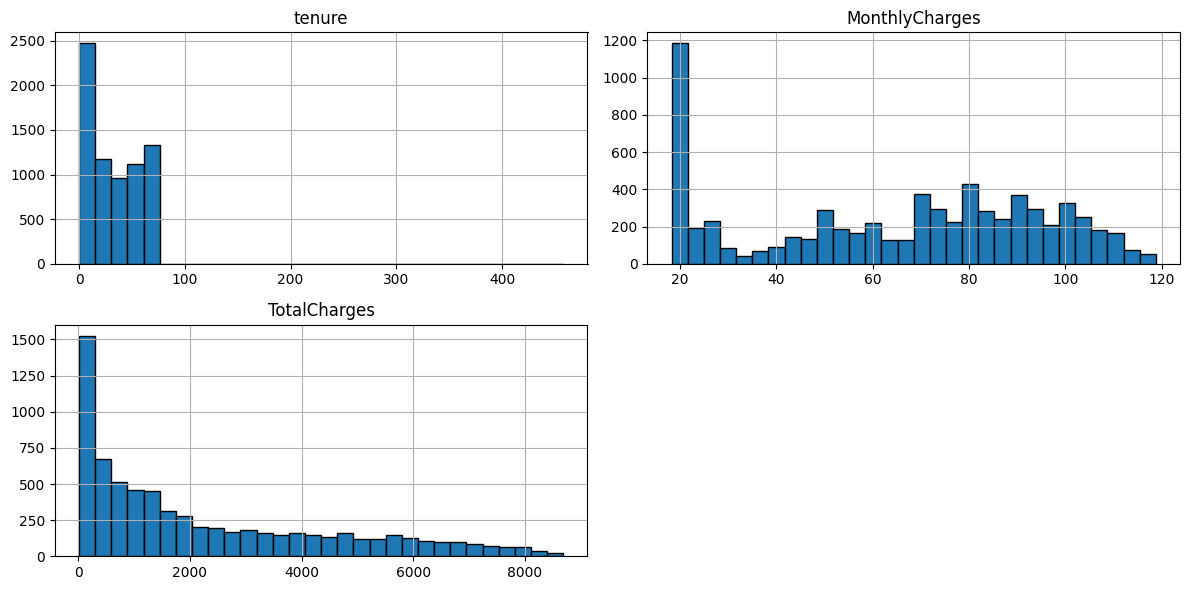

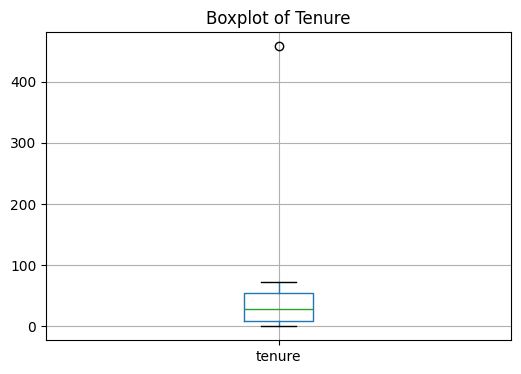

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
numerical_df.boxplot(column='tenure', ax=ax)
plt.title('Boxplot of Tenure')
plt.show()

The tenure feature shows a clear outlier above around 400 months, well beyond the typical range of 0 to 80 months.

In [ ]:
numerical_df.tenure.describe()

,tenure
count,7043.000000
mean,32.435752
std,25.075228
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,458.000000


**There we see the max monnth is 458! which is an outlier.**

Let's generate the correlation matrix

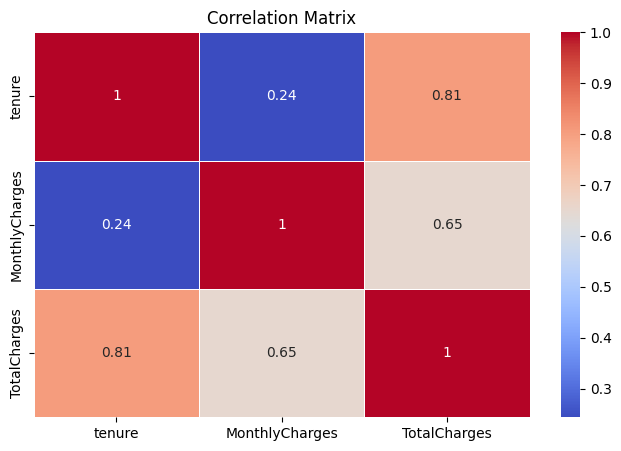

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = numerical_df.corr()

# Set up the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Let's check the unique value count per each categorical variables

In [ ]:
categorical_cols

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
df.groupby('contract').count().show()

+--------------+-----+
|      contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



In [ ]:
for column in categorical_cols:
  df.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

In [ ]:
for column in categorical_cols:
    unique_count = df.select(col).distinct().count()
    print(f"'{col}' has {unique_count} unique values")

'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values
'Churn' has 2 unique values


Let's find number of null values in all of our dataframe columns

In [ ]:
from pyspark.sql.functions import col, sum

# Count nulls in each column
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

another code to find the same:

In [ ]:
for column in df.columns:
 df.select(count(when(col(column).isNull(),column)).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

In [ ]:
from pyspark.sql.functions import col, sum

# Create a list to hold columns with missing values
cols_with_missing = []

# Loop over each column and check if it has any nulls
for c in df.columns:
    null_count = df.select(sum(col(c).isNull().cast("int"))).collect()[0][0]
    if null_count > 0:
        cols_with_missing.append(c)

print("Columns with missing values:", cols_with_missing)

Columns with missing values: ['TotalCharges']


### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [ ]:
c_missing_values = ["TotalCharges"]

Creating our Imputer

In [ ]:
imputer = Imputer(
    inputCols=c_missing_values,
    outputCols=[c + "_imputed" for c in c_missing_values]
).setStrategy("mean")

Use Imputer to fill the missing values

In [ ]:
df_imputed = imputer.fit(df).transform(df)

Let's check the missing value counts again

In [ ]:
from pyspark.sql.functions import col, sum

df_imputed.select(sum(col("TotalCharges").isNull().cast("int")).alias("null_count")).show()

+----------+
|null_count|
+----------+
|         0|
+----------+



In [ ]:
df_imputed.select(sum(col("TotalCharges_imputed").isNull().cast("int")).alias("null_count")).show()

+----------+
|null_count|
+----------+
|         0|
+----------+



In [ ]:
df_imputed.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_imputed.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+--------------------+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|    

pushing the updated df_imputed back to original df for the convenience of applying ml model later

In [ ]:
df = df_imputed

**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [ ]:
df.filter(col("tenure") > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+--------------------+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|       

Let's drop the outlier row

In [ ]:
print("before_removing_outlier",df.count())
df = df.filter(col("tenure") < 100)
print("after_removing_outlier",df.count())

before_removing_outlier 7042
after_removing_outlier 7042


Outliers with tenure ≥ 100 were already removed in a previous step (coz i used this code before "df = df.filter(col("tenure") < 100)" , so this filtering did not change the dataset size.

**Saving the cleaned data to the drive coz i'm going to sleep now and will continue again with the remaining 4 tasks. Hyvää yöta mulle!**

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df.write.parquet(f"/content/drive/MyDrive/cleaned_data_{timestamp}")

In [ ]:
print(f"✅ Data saved to: /content/drive/MyDrive/cleaned_data_{timestamp}")

✅ Data saved to: /content/drive/MyDrive/cleaned_data_20250717_011503


I'm back now, so continuing off where I left.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.parquet("/content/drive/MyDrive/cleaned_data_20250717_011503/part-00000-550ecb43-9ab3-4edc-859b-3eb6a34e0c8b-c000.snappy.parquet")

In [ ]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------

In [ ]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- TotalCharges_imputed: double (nullable = true)



In [ ]:
df = df.drop("TotalCharges")

In [ ]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges_imputed']

Dropped `TotalCharges` column

Dropped `TotalCharges` since missing values were imputed into `TotalCharges_imputed` to avoid duplication.


### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [ ]:
if "numerical_features_vectors" in df.columns:
    df = df.drop("numerical_features_vectors")

In [ ]:
numerical_vector_assembler = VectorAssembler(inputCols= numerical_cols, outputCol= "numerical_features_vectors")
df = numerical_vector_assembler.transform(df)

In [ ]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+--------------------+--------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|Churn|TotalCharges_imputed|numerical_features_vectors|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+-----

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [ ]:
if "numerical_features_scaled" in df.columns:
    df = df.drop("numerical_features_scaled")

In [ ]:
scaler = StandardScaler(inputCol = "numerical_features_vectors", outputCol= "numerical_features_scaled", withStd = True, withMean = True)
df = scaler.fit (df).transform(df)

In [ ]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+--------------------+--------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|Churn|TotalCharges_imputed|numerical_features_vectors|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+------------

**Feature Preparation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [ ]:
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed")
    df = indexer.fit(df).transform(df)

In [ ]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+--------------------+--------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+----------------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|  

In [ ]:
categorical_indexed_cols = [col + "_indexed" for col in categorical_cols]

In [ ]:
categorical_indexed_cols

['customerID_indexed',
 'gender_indexed',
 'SeniorCitizen_indexed',
 'Partner_indexed',
 'Dependents_indexed',
 'PhoneService_indexed',
 'MultipleLines_indexed',
 'InternetService_indexed',
 'OnlineSecurity_indexed',
 'OnlineBackup_indexed',
 'DeviceProtection_indexed',
 'TechSupport_indexed',
 'StreamingTV_indexed',
 'StreamingMovies_indexed',
 'Contract_indexed',
 'PaperlessBilling_indexed',
 'PaymentMethod_indexed',
 'Churn_indexed']

Let's combine all of our categorifal features in to one feature vector.

In [ ]:
categorical_indexed_cols.remove("customerID_indexed")
categorical_indexed_cols.remove("Churn_indexed")

In [ ]:
categorical_indexed_cols

['gender_indexed',
 'SeniorCitizen_indexed',
 'Partner_indexed',
 'Dependents_indexed',
 'PhoneService_indexed',
 'MultipleLines_indexed',
 'InternetService_indexed',
 'OnlineSecurity_indexed',
 'OnlineBackup_indexed',
 'DeviceProtection_indexed',
 'TechSupport_indexed',
 'StreamingTV_indexed',
 'StreamingMovies_indexed',
 'Contract_indexed',
 'PaperlessBilling_indexed',
 'PaymentMethod_indexed']

In [ ]:
categorical_vector_assembler = VectorAssembler(inputCols= categorical_indexed_cols, outputCol= "categorical_features_vectors")
df = categorical_vector_assembler.transform(df)

In [ ]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+--------------------+--------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+----------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|   

Sparse Vector Format Explanation

Example: `(16, [0, 2, 5], [1.0, 0.0, 1.0])`

- **16**: Total number of features in the vector (vector length)
- **[0, 2, 5]**: Indices of features with non-zero (or explicitly set) values
- **[1.0, 0.0, 1.0]**: Corresponding values for those indices

> Note: Values not listed are implicitly zero. Sometimes zeros appear explicitly depending on transformations.

To see the full vector as a dense array, use PySpark's `vector_to_array()` function.


**Now let's combine categorical and numerical feature vectors.**
(here instead of using the original numerical_features_vector, we use the numerical_features_scaled column because the raw numerical values may have different scales or units. Scaling ensures that all numerical features contribute equally to the model training and prevents bias toward features with larger ranges)

In [ ]:
final_vector_assembler = VectorAssembler(inputCols= ["categorical_features_vectors", "numerical_features_scaled"], outputCol= "final_feature_vector")
df = final_vector_assembler.transform(df)

In [ ]:
df.select(["final_feature_vector", "Churn_indexed"]).show()

+--------------------+-------------+
|final_feature_vector|Churn_indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



Next, using PySpark, a decision tree machine learning model will be created to predict customer churn based on numerical and categorical features that is made above.

### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [ ]:
df_train, df_test = df.randomSplit([0.7, 0.3], seed = 100)
train.count()

4931

Now let's create and train our desicion tree

In [ ]:
train.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+-----+--------------------+--------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+----------------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|  

In [ ]:
dt = DecisionTreeClassifier(featuresCol="final_feature_vector", labelCol="Churn_indexed", maxDepth=7, maxBins=32)
dt_model = dt.fit(df_train)

setting maxdepth as 3 coz if it's more, there risk of model memorizing the training data instead of learning and complexities i.e., overfitting and if it's too low, theres risk of shallowness where not sufficient capture of data, i.e., underfitting.

- **(initially set at 3 now it's changed to 7 after hyperparamter tuning and plotting the graph)**

Let's make predictions on our test data

In [ ]:
# Use the trained model to make predictions on the test set
predictions = dt_model.transform(df_test)

# Show a few prediction results
predictions.select("Churn", "Churn_indexed", "prediction").show()

+-----+-------------+----------+
|Churn|Churn_indexed|prediction|
+-----+-------------+----------+
|  Yes|          1.0|       1.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|  Yes|          1.0|       1.0|
|   No|          0.0|       0.0|
|  Yes|          1.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|  Yes|          1.0|       1.0|
|   No|          0.0|       0.0|
|   No|          0.0|       1.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
|   No|          0.0|       0.0|
+-----+-------------+----------+
only showing top 20 rows



- The `prediction` column is automatically created by the model's `.transform()` method to store predicted labels.


### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed', rawPredictionCol='rawPrediction', metricName='areaUnderROC')

In [ ]:
auc_test = evaluator.evaluate(predictions)
auc_test

0.7732476301172237

An AUC of 0.76 means the model is fairly good as it correctly ranks positives over negatives ~76% of the time.

An AUC close to 1 (like 0.95 or 0.98) would be excellent.

An AUC close to 0.5 means that the model isn’t useful.

- Note: rawPredictionCol='rawPrediction' is used because the AUC metric requires raw scores (not class labels) to compute how well the model ranks positives vs. negatives.

Let's get the AUC for our `training` set

In [ ]:
predictions_train = dt_model.transform(train)
auc_train = evaluator.evaluate(predictions_train)
auc_train

0.7987421344101505

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [ ]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [ ]:
maxDepths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
test_auc_scores, train_auc_scores = evaluate_dt(maxDepths) #calling the function with the list
print(test_auc_scores)
print(train_auc_scores)

[0.7788716846464305, 0.7617045633750168, 0.6707372773945599, 0.5568304606596539, 0.6941230411597387, 0.7732476301172237, 0.7549526607519376, 0.7484139453656599, 0.7448785416824854, 0.7551272990637284, 0.7319220143565541, 0.7116365186816268, 0.7193229406989037, 0.7069744350538224, 0.7050253780422988]
[0.7789865142153861, 0.7712918493814211, 0.682686668771004, 0.5698478631124324, 0.7096356017000698, 0.7987421344101505, 0.788835504950852, 0.7950492737730392, 0.8209106163822248, 0.8614776933946862, 0.8880322726550576, 0.9054592884069872, 0.9428490045687596, 0.9682891653032488, 0.979503879400507]


Let's visualize our results

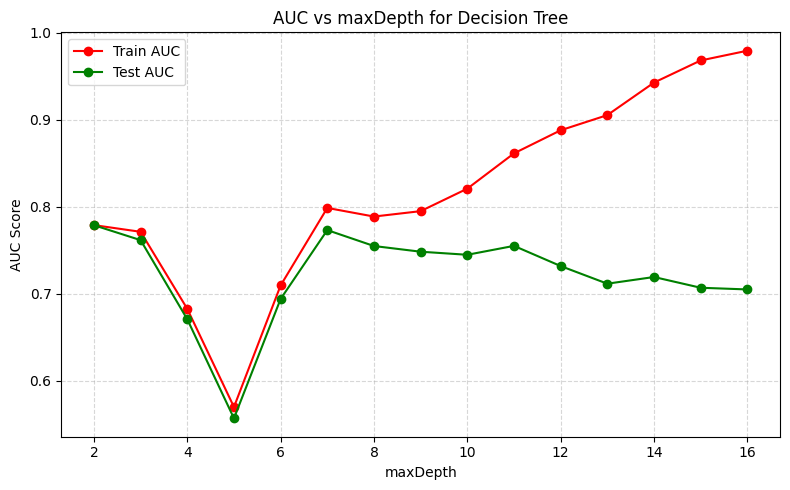

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(maxDepths, train_auc_scores, marker='o', label='Train AUC', color='red')
plt.plot(maxDepths, test_auc_scores, marker='o', label='Test AUC', color='green')
plt.title('AUC vs maxDepth for Decision Tree')
plt.xlabel('maxDepth')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame()
df["maxDepth"] = maxDepths
df["train_auc_scores"] = train_auc_scores
df["test_auc_scores"] = test_auc_scores
px.line (df, x = "maxDepth", y = ["train_auc_scores", "test_auc_scores"])

as the maxDepth increases, we can see the the train accuracy also increase. However, when the train score reaches its highest score at above 0.95, the test score decreases and there's a wide gap between the two. This is when the model is so perfect for the training set that it doesn't capture any kind of pattern in test set, a data it has never seen before. This is called overtfitting.

On the other hand, if we look where the maxDepth is 5, both the train and test accuracy is raelly low. This is called underfitting. So, the best practice is to find the the maxDepth that provide high accuracy for both train and test accuracy are at their highest point. So the optimum maxDepth is 7.

**So now we will go back to the previous task where we trained the model and change the maxDepth to 7 and rerun the accuracy score for train and test set **

### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn. The goal is to provide business recommendations based on model predictions. To do that effectively, it's important to understand why the model made certain predictions.

That’s where feature importance comes in.
- Feature importance tells us which features (customer attributes) had the most influence on the model’s decision to classify a customer as likely to churn or not.


In [ ]:
final_feature_names = categorical_indexed_cols + numerical_cols

In [ ]:
# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    "Feature": final_feature_names,
    "Importance": importances.toArray()
}).sort_values(by="Importance", ascending=False)

In [ ]:
import plotly.express as px

fig = px.bar(
    feature_importance_df.head(20),  # top 20 important features
    x="Importance",
    y="Feature",
    orientation="h",
    title="Top 20 Feature Importances (Decision Tree)",
    width=800,
    height=600
)
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

Let's create a bar chart to visualize the customer churn per contract type

In [ ]:
df

DataFrame[customerID: string, gender: string, SeniorCitizen: string, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string]

In [ ]:
from pyspark.sql.functions import col, when, count, sum

# Assuming original df has 'Contract' and 'Churn' columns with churn as 'Yes'/'No'

churn_by_contract = (
    df.groupby("Contract")
      .agg(
          count("*").alias("total_customers"),
          sum(when(col("Churn") == "Yes", 1).otherwise(0)).alias("churned_customers")
      )
      .withColumn("churn_rate", col("churned_customers") / col("total_customers") * 100)
      .orderBy("churn_rate", ascending=False)
)

churn_by_contract.show()

+--------------+---------------+-----------------+------------------+
|      Contract|total_customers|churned_customers|        churn_rate|
+--------------+---------------+-----------------+------------------+
|Month-to-month|           3875|             1655| 42.70967741935484|
|      One year|           1473|              166|11.269517990495586|
|      Two year|           1695|               48| 2.831858407079646|
+--------------+---------------+-----------------+------------------+



In [ ]:
# Group by Contract and Churn, count rows, convert to Pandas
df_grouped = df.groupby(["Contract", "Churn"]).count().toPandas()

# Plot stacked bar chart showing churn distribution per contract
fig = px.bar(df_grouped, x="Contract", y="count", color="Churn",
             title="Customer Churn Count by Contract Type",
             labels={"count": "Number of Customers"})
fig.show()

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.

### Conclusion: Customer Churn by Contract Type

- **Month-to-month** customers have the highest churn rate (~43%), indicating a high risk of leaving.
- **One year** contract customers show a much lower churn rate (~11%), suggesting better retention.
- **Two year** contract customers have the lowest churn rate (~3%), indicating strong customer loyalty.

**Insight:** Longer contract durations are associated with significantly reduced churn, highlighting the importance of promoting long-term contracts to improve customer retention.
